In [28]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

from salishsea_tools import viz_tools

DFO data from 2013 - Mar 2020

PSF data from 2015 - 2017

PUG data from 2015 - 2018

ONC data from 2014 - 2022 Ferry data from 2013 - 2022

In [29]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 0
dbin = 0.5
scale = 24

cmap = cm.rain #'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'

In [30]:
foramt = "{:.3}"
myformat = {'bias': foramt, 'rmse': foramt, 'crmse':foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

def use_f_2(x):
    return "%.2f" % x

In [31]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')

In [32]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [33]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [34]:
def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

In [35]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [36]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
#    print (model.summary())
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [37]:
def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst

In [38]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean()

In [39]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
#    temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
    return temp1

In [40]:
def filter_bad_data(temp1):
# bad data in Puget Sound (pugts)
    temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
# bad onc data
 #   temp1_nobox_nohook = temp1_nohook[(temp1_nohook['depth (m)'] != 107) | (temp1_nohook.SA > 29)]
# bad ferry data
  #  temp1_clean = temp1_nobox_nohook[((temp1_nobox_nohook.SA > 0.2) | (temp1_nobox_nohook.mod_vosaline - temp1_nobox_nohook.SA < 20)) 
  #                                   & ((temp1_nobox_nohook.Lon > -123.8) | (temp1_nobox_nohook.SA > 14))]
    return temp1_nohook

In [41]:
def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    print (temp1[temp1.k <= idepth])
    if boxes:
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    print (swillmott(select, 'SA', 'mod_vosaline'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts, xedges, yedges, color = ax.hist2d(select[one], 
                                              select[two], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
    fig.colorbar(color, ax=ax)
   
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts

In [42]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series lime green.
    '''

    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('limegreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [43]:
def plot_allyears(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False):
    if reverse:
        string = '_reverse'
    else:
        string = ''
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    startyear = min(years[0], years_psf[0], years_pug[0])#, years_onc[0])
    endyear = max(years[-1], years_psf[-1], years_pug[-1])#, years_onc[-1])
    fig.suptitle(f'Year {startyear}-{endyear}')
    print (idepth, jdepth)
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv')
    for year in years_psf:
        pieces1.append(
            f'//data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
         #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    d201905, counts1 = plot_and_stats(filter_bad_data(temp1), '201905R', idepth, jdepth, fig, axs[0], whichdepths, reverse, string)
    
    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
    d202111, counts2 = plot_and_stats(filter_bad_data(temp2), '202111', idepth, jdepth, fig, axs[1], whichdepths, reverse, string)

    alltogether = pd.concat([d201905, d202111], axis=0)
    
    fig.savefig(f'{whichdepths}_{field}{string}_201905_202111_for_allyears.png')
    
    f = open(f'./{whichdepths}_{field}{string}_201905_202111_for_allyears_table.tex', 'w')
    f.write(alltogether.to_latex(column_format='lcccccccccc', 
            formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    f.close()
    return alltogether, counts1, counts2

In [44]:
def stats_only(temp1, name, idepth, jdepth, corn, boxname):
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    number, tbias = bias(select, obsn, modn)
    if number > 0:
        trmse = rmse(select, obsn, modn)
        tcrmse = crmse(trmse, tbias)
        tswillmott = swillmott(select, obsn, modn)
        a1, b1, syst, nonsyst = wolfram_perp(select, obsn, modn)
        tspread = spread(select, obsn, modn)
        Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread,
          'region': boxname}
        dCp2 = pd.DataFrame(data=Cp2, index=[name])
    else:
        dCp2 = 0
    return number, dCp2

In [45]:
def stats_allregions(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths):
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')    
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')    
    temp1 = read_pieces(pieces1)
    
    number, alltogether = stats_only(filter_bad_data(temp1), '201905R', idepth, jdepth, boxes[0], boxnames[0])
    for boxname, corn in zip(boxnames[1:], boxes[1:]):
        number, d201905 = stats_only(filter_bad_data(temp1), '201905R', idepth, jdepth, corn, boxname)
        if number > 0:
            alltogether = pd.concat([alltogether, d201905], axis=0)

    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
   
    for boxname, corn in zip(boxnames, boxes):
        number, d202111 = stats_only(filter_bad_data(temp2), '202111', idepth, jdepth, corn, boxname)
        if number > 0:
            alltogether = pd.concat([alltogether, d202111], axis=0)
    f = open(f'./{whichdepths}_{field}_201905_202111_for_allregions_table.tex', 'w')
    f.write(alltogether.to_latex(column_format='lccccccccccl', 
            formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, None]))
    f.close()
    return alltogether

In [46]:
def stats_and_plot(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, box, boxname, whichdepths):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle(f'{boxname} Year {years[0]}-{years[-1]}')
    
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')   
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')   
    temp1 = read_pieces(pieces1)
    
    alltogether, counts = plot_and_stats(filter_bad_data(temp1), '201905R', idepth, jdepth, fig, axs[0], whichdepths, False, '', boxes=True, box=box, boxname=boxname)

    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
    d202111, counts = plot_and_stats(filter_bad_data(temp2), '202111', idepth, jdepth, fig, axs[1], whichdepths, False, '', boxes=True, box=box, boxname=boxname)
    
    plot_profiles(temp1, temp2, axs[2], axs[3], box, boxname)
    
    
    alltogether = pd.concat([alltogether, d202111], axis=0)

In [47]:
def plot_profiles(temp1, temp2, ax, ax2, box, boxname):

    corn = box
    temp1['diff'] = temp1[modn] - temp1[obsn]
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    kls = len(select.groupby('k')[obsn])
    ax.plot(select.groupby('k')[obsn].mean(), deptht[:kls], 'o-', c='tab:green', label='Observations')
    ax.plot(select.groupby('k')[modn].mean(), deptht[:kls], 'o-', c='tab:blue', label='201905')
    ax2.plot(select.groupby('k')['diff'].mean(), deptht[:kls], '-', c='tab:blue', label='201905')
    ax.fill_betweenx(deptht[:kls], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:blue')
    ax2.fill_betweenx(deptht[:kls], select[['k', 'diff']].groupby('k').quantile(q=0.25)['diff'], select[['k', 'diff']].groupby('k').quantile(q=0.75)['diff'], alpha=0.2, color='tab:blue')
    
    temp2['diff'] = temp2[modn] - temp2[obsn]
    select = temp2[(temp2.k >= idepth) & (temp2.k <= jdepth) &
                              (temp2.j >= corn[0]) & (temp2.j <= corn[1]) &
                              (temp2.i >= corn[2]) & (temp2.i <= corn[3])]
    
    ax.plot(select.groupby('k')[modn].mean(), deptht[:kls], 'o-', c='tab:orange', label='202111')
    ax2.plot(select.groupby('k')['diff'].mean(), deptht[:kls], '-', c='tab:orange', label='202111')
    ax.fill_betweenx(deptht[:kls], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:orange')
    ax.fill_betweenx(deptht[:kls], select[['k', obsn]].groupby('k').quantile(q=0.25)[obsn], select[['k', obsn]].groupby('k').quantile(q=0.75)[obsn], alpha=0.2, color='tab:orange')
    ax2.fill_betweenx(deptht[:kls], select[['k', 'diff']].groupby('k').quantile(q=0.25)['diff'], select[['k', 'diff']].groupby('k').quantile(q=0.75)['diff'], alpha=0.2, color='tab:orange')
    
    ax.invert_yaxis()
    ax2.invert_yaxis()
    
    ax.legend()
    ax2.legend()
    ax.set_title(f'{field} Profiles')
    ax2.set_title(f'{field} Difference Profiles')
    ax2.grid();

In [48]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

## Me change

In [49]:
import salishsea_tools.river_202108 as rivers

In [50]:
def river_box(w_shed, r_call, box_side):
    river_idx = [rivers.prop_dict[w_shed][r_call]['i'], rivers.prop_dict[w_shed][r_call]['j']]
    river_range = [river_idx[0] - box_side, river_idx[0] + box_side, river_idx[1] - box_side, river_idx[1] + box_side]

    if (river_range[0] < 0):
        river_range[0] = 0
        river_range[1] = box_side*2

    if (898 - river_range[1] < 0):
        river_range[0] = 898-box_side*2
        river_range[1] = 898

    if (398 - river_range[3] < 0):
        river_range[2] = 398-box_side*2
        river_range[3] = 398

    return river_range

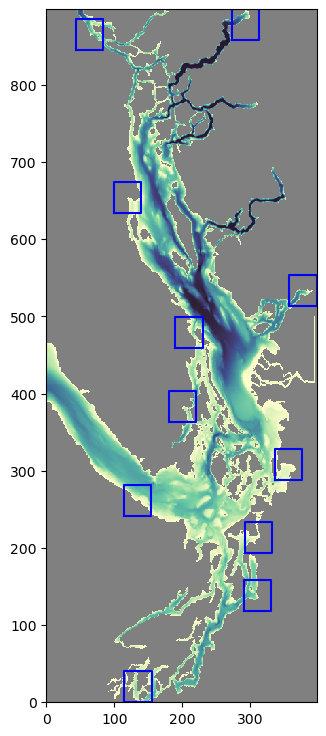

In [51]:
box_size = 20

fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);

# order (CW starting under the Fraser): Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish
Nooksack = river_box('fraser', 'Nooksack', box_size)
plot_box(ax, Nooksack, 'b')

Skagit = river_box('skagit', 'Skagit1', box_size)
plot_box(ax, Skagit, 'b')

Snohomish = river_box('skagit', 'SnohomishAllenQuilceda', box_size)
plot_box(ax, Snohomish, 'b')

Nisqually = river_box('puget', 'NisquallyMcAllister', box_size)
plot_box(ax, Nisqually, 'b')

Elwha = river_box('jdf', 'Elwha', box_size)
plot_box(ax, Elwha, 'b')

Cowichan = river_box('evi_s', 'Cowichan1', box_size)
plot_box(ax, Cowichan, 'b')

Nanaimo = river_box('evi_s', 'Nanaimo1', box_size)
plot_box(ax, Nanaimo, 'b')

Puntledge = river_box('evi_s', 'Puntledge', box_size)
plot_box(ax, Puntledge, 'b')

Salmon = river_box('evi_n', 'SalmonSayward', box_size)
plot_box(ax, Salmon, 'b')

Homathko = river_box('bute', 'Homathko', box_size)
plot_box(ax, Homathko, 'b')

Squamish = river_box('howe', 'Squamish', box_size)
plot_box(ax, Squamish, 'b')

# boxes = [Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish]
# boxnames = ['Nooksack', 'Skagit', 'Snohomish', 'Nisqually', 'Elwha', 'Cowichan', 'Nanaimo', 'Puntledge', 'Salmon', 'Homathko', 'Squamish']

# none in Elwha and Homathko with size 20 box
boxes = [Nooksack, Skagit, Snohomish, Nisqually, Cowichan, Nanaimo, Puntledge, Salmon, Squamish]
boxnames = ['Nooksack', 'Skagit', 'Snohomish', 'Nisqually', 'Cowichan', 'Nanaimo', 'Puntledge', 'Salmon', 'Squamish']


# SoG_center = [450, 550, 200, 300]
# plot_box(ax, SoG_center, 'b')
# SoG_north = [650, 730, 100, 200]
# plot_box(ax, SoG_north, 'g')
# SoG_south = [320, 380, 280, 350]
# plot_box(ax, SoG_south, 'k')
# Haro_Boundary = [290, 350, 210, 280]
# plot_box(ax, Haro_Boundary, 'g')
# JdF_east = [200, 290, box_sixe0, 260]
# plot_box(ax, JdF_east, 'b')
# JdF_west = [250, 425, 25, 125]
# plot_box(ax, JdF_west, 'k')
# PS_main = [20, 150, 200, 280]
# plot_box(ax, PS_main, 'k')
# SS_all = [0, 898, 0, 398]
# boxes = [SS_all, SoG_south,SoG_center, SoG_north, PS_main, Haro_Boundary, JdF_west, JdF_east]
# boxnames = ['SS_all', 'SoG_south', 'SoG_center', 'SoG_north', 'PS_main', 'Haro_Boundary',
#            'JdF_west', 'JdF_east']
# Fraser_plume = [380, 460, 260, 330]
# plot_box(ax, Fraser_plume, 'm')

In [52]:
# results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
#                            [2015, 2016, 2017, 2018, 2019], 
#                            idepth, jdepth, 'test')

In [53]:
idepth = 0
jdepth = 5

# results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
#                            [2015, 2016, 2017, 2018, 2019], 
#                            idepth, jdepth, 'top5m')
for boxname in boxnames:
    if results[results.region == boxname].number[0] > 0:
        print(f'\033[1m{boxname}\033[1m')
        display(results[results.region == boxname].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

Nooksack


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,493,-0.372,1.34,1.29,0.194,0.108,2.68,0.413,1.21,0.145
202111,493,-0.0242,1.24,1.24,0.187,0.221,6.23,0.368,1.08,0.289


Skagit


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,760,1.37,3.73,3.47,0.213,0.514,14.0,3.01,1.85,0.686
202111,760,-0.362,4.76,4.74,0.202,-0.246,-6.42,1.34,5.24,-0.335


Snohomish


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,811,-0.0543,2.43,2.43,0.152,0.173,4.46,0.61,2.17,0.245
202111,811,-0.422,2.04,2.0,0.0726,-0.229,-6.41,0.91,2.07,-0.439


Nisqually


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,4841,-0.791,1.01,0.621,0.321,0.419,11.3,0.88,0.417,0.556
202111,4841,-0.868,0.946,0.375,0.187,-0.192,-6.41,0.886,0.367,-0.396


Cowichan


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,8526,-1.34,1.97,1.45,0.346,-0.88,-26.6,1.74,1.78,-1.55
202111,8526,-1.12,1.6,1.14,0.268,-0.511,-15.8,1.29,1.3,-1.08


Nanaimo


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,367,-0.777,1.79,1.61,0.142,-0.551,-15.7,1.33,1.69,-1.94
202111,367,-0.419,1.48,1.42,0.114,-0.354,-10.0,0.813,1.52,-1.7


Puntledge


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1366,0.132,0.928,0.918,0.181,0.241,6.77,0.333,0.78,0.322
202111,1366,0.445,1.01,0.901,0.197,0.234,6.9,0.535,0.768,0.318


Salmon


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,180,0.188,0.296,0.228,0.164,0.253,7.96,0.215,0.183,0.386
202111,180,0.206,0.315,0.239,0.203,0.367,11.5,0.255,0.161,0.534


Squamish


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,25,0.182,2.1,2.09,0.228,-0.543,-14.3,1.12,2.5,-0.762
202111,25,0.928,1.72,1.44,0.187,0.0196,1.45,0.929,1.43,0.029


In [54]:
# # for some reason no obs in top 30m deeper than 7?
# idepth = 0
# jdepth = 30
# region = 'Nisqually'

# results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
#                            [2015, 2016, 2017, 2018, 2019], 
#                            idepth, jdepth, 'test')

# print(f'\033[1m{region}\033[1m')
# display(results[results.region == region].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

In [55]:
# # for some reason no obs in top 30m deeper than 7?
# idepth = 0
# jdepth = 5
# region = 'Nisqually'

# print(f'\033[1m{region}\033[1m')
# display(results[results.region == region].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

Nooksack


/tmp/ipykernel_2096566/2185682482.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(alltogether.to_latex(column_format='lccccccccccl',


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,493,-0.372,1.34,1.29,0.194,0.108,2.68,0.413,1.21,0.145
202111,493,-0.0242,1.24,1.24,0.187,0.221,6.23,0.368,1.08,0.289


         Unnamed: 0    Year  Month   Day       Hour        Lat         Lon  \
0                 0  2013.0    1.0  10.0  17.118056  49.329667 -124.081000   
1353           1353  2013.0    2.0  13.0  16.696111  49.318167 -123.934833   
2895           2895  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
2896           2896  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
3533           3533  2013.0    3.0   7.0  16.628056  49.316500 -123.945667   
...             ...     ...    ...   ...        ...        ...         ...   
2802459      171184     NaN    NaN   NaN        NaN  49.171881 -123.630172   
2802460      171185     NaN    NaN   NaN        NaN  49.174657 -123.637464   
2802461      171186     NaN    NaN   NaN        NaN  49.177499 -123.644701   
2802462      171187     NaN    NaN   NaN        NaN  49.180270 -123.652008   
2802463      171188     NaN    NaN   NaN        NaN  49.183008 -123.659329   

                Z         SA        CT  ...  conservative tempe

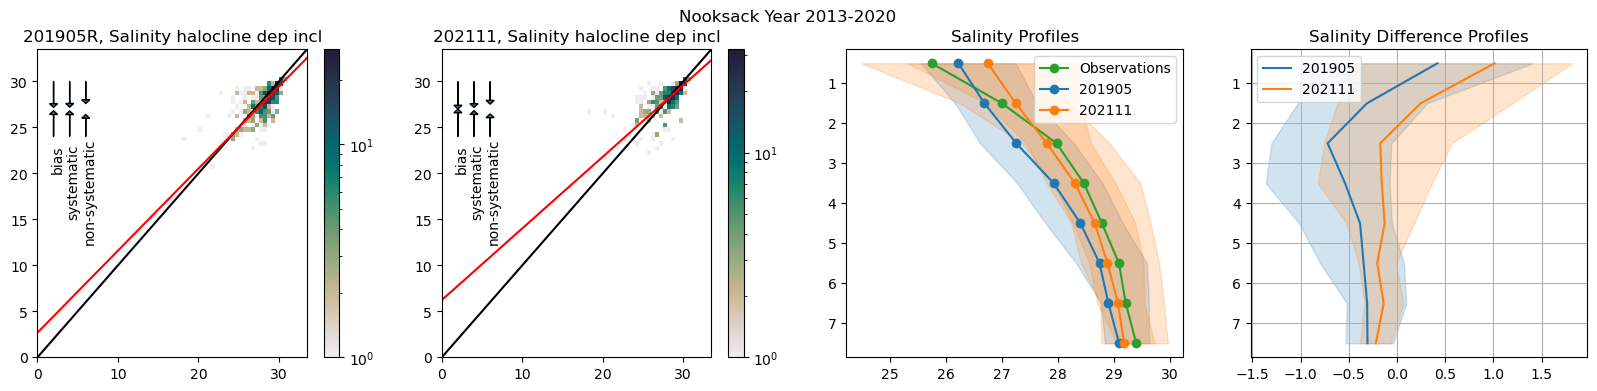

In [56]:
# for some reason no obs in top 30m deeper than 7?
idepth = 0
jdepth = 30
region = 'Nooksack'

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
                           [2015, 2016, 2017, 2018, 2019], 
                           idepth, jdepth, 'test')

print(f'\033[1m{region}\033[1m')
display(results[results.region == region].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
               [2015, 2016, 2017, 2018, 2019],
               idepth, jdepth, Nooksack, region, 'halocline dep incl')

Skagit


/tmp/ipykernel_2096566/2185682482.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(alltogether.to_latex(column_format='lccccccccccl',


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,760,1.37,3.73,3.47,0.213,0.514,14.0,3.01,1.85,0.686
202111,760,-0.362,4.76,4.74,0.202,-0.246,-6.42,1.34,5.24,-0.335


         Unnamed: 0    Year  Month   Day       Hour        Lat         Lon  \
0                 0  2013.0    1.0  10.0  17.118056  49.329667 -124.081000   
1353           1353  2013.0    2.0  13.0  16.696111  49.318167 -123.934833   
2895           2895  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
2896           2896  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
3533           3533  2013.0    3.0   7.0  16.628056  49.316500 -123.945667   
...             ...     ...    ...   ...        ...        ...         ...   
2802459      171184     NaN    NaN   NaN        NaN  49.171881 -123.630172   
2802460      171185     NaN    NaN   NaN        NaN  49.174657 -123.637464   
2802461      171186     NaN    NaN   NaN        NaN  49.177499 -123.644701   
2802462      171187     NaN    NaN   NaN        NaN  49.180270 -123.652008   
2802463      171188     NaN    NaN   NaN        NaN  49.183008 -123.659329   

                Z         SA        CT  ...  conservative tempe

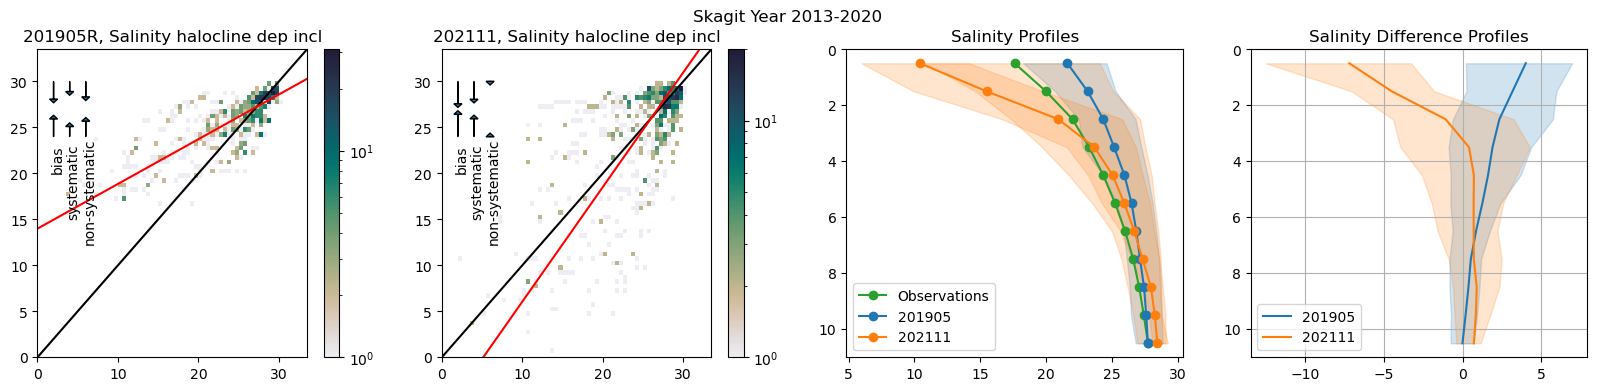

In [57]:
# number of obs didnt change when I increased the depth to 10m
idepth = 0
jdepth = 10
region = 'Skagit'

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
                           [2015, 2016, 2017, 2018, 2019], 
                           idepth, jdepth, 'test')

print(f'\033[1m{region}\033[1m')
display(results[results.region == region].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
               [2015, 2016, 2017, 2018, 2019],
               idepth, jdepth, Skagit, region, 'halocline dep incl')


Snohomish


/tmp/ipykernel_2096566/2185682482.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(alltogether.to_latex(column_format='lccccccccccl',


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,811,-0.0543,2.43,2.43,0.152,0.173,4.46,0.61,2.17,0.245
202111,811,-0.422,2.04,2.0,0.0726,-0.229,-6.41,0.91,2.07,-0.439


         Unnamed: 0    Year  Month   Day       Hour        Lat         Lon  \
0                 0  2013.0    1.0  10.0  17.118056  49.329667 -124.081000   
1353           1353  2013.0    2.0  13.0  16.696111  49.318167 -123.934833   
2895           2895  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
2896           2896  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
3533           3533  2013.0    3.0   7.0  16.628056  49.316500 -123.945667   
...             ...     ...    ...   ...        ...        ...         ...   
2802459      171184     NaN    NaN   NaN        NaN  49.171881 -123.630172   
2802460      171185     NaN    NaN   NaN        NaN  49.174657 -123.637464   
2802461      171186     NaN    NaN   NaN        NaN  49.177499 -123.644701   
2802462      171187     NaN    NaN   NaN        NaN  49.180270 -123.652008   
2802463      171188     NaN    NaN   NaN        NaN  49.183008 -123.659329   

                Z         SA        CT  ...  conservative tempe

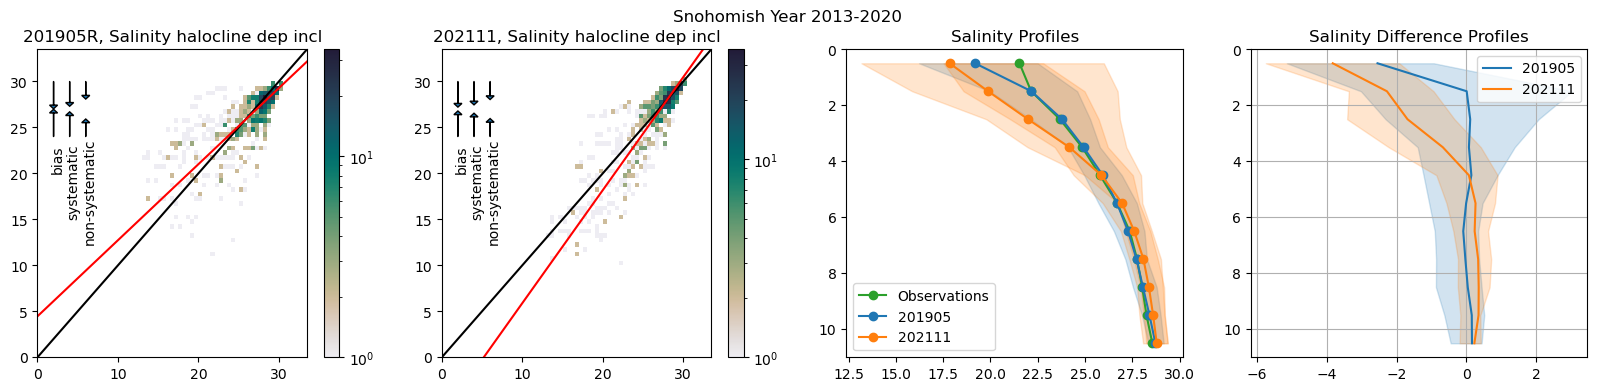

In [58]:
idepth = 0
jdepth = 10
region = 'Snohomish'

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
                           [2015, 2016, 2017, 2018, 2019], 
                           idepth, jdepth, 'test')

print(f'\033[1m{region}\033[1m')
display(results[results.region == region].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
               [2015, 2016, 2017, 2018, 2019],
               idepth, jdepth, Snohomish, region, 'halocline dep incl')

Nisqually


/tmp/ipykernel_2096566/2185682482.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(alltogether.to_latex(column_format='lccccccccccl',


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,7189,-0.77,0.976,0.6,0.318,0.414,11.2,0.855,0.403,0.554
202111,7189,-0.827,0.896,0.344,0.181,-0.163,-5.53,0.84,0.34,-0.333


         Unnamed: 0    Year  Month   Day       Hour        Lat         Lon  \
0                 0  2013.0    1.0  10.0  17.118056  49.329667 -124.081000   
1353           1353  2013.0    2.0  13.0  16.696111  49.318167 -123.934833   
2895           2895  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
2896           2896  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
3533           3533  2013.0    3.0   7.0  16.628056  49.316500 -123.945667   
...             ...     ...    ...   ...        ...        ...         ...   
2802459      171184     NaN    NaN   NaN        NaN  49.171881 -123.630172   
2802460      171185     NaN    NaN   NaN        NaN  49.174657 -123.637464   
2802461      171186     NaN    NaN   NaN        NaN  49.177499 -123.644701   
2802462      171187     NaN    NaN   NaN        NaN  49.180270 -123.652008   
2802463      171188     NaN    NaN   NaN        NaN  49.183008 -123.659329   

                Z         SA        CT  ...  conservative tempe

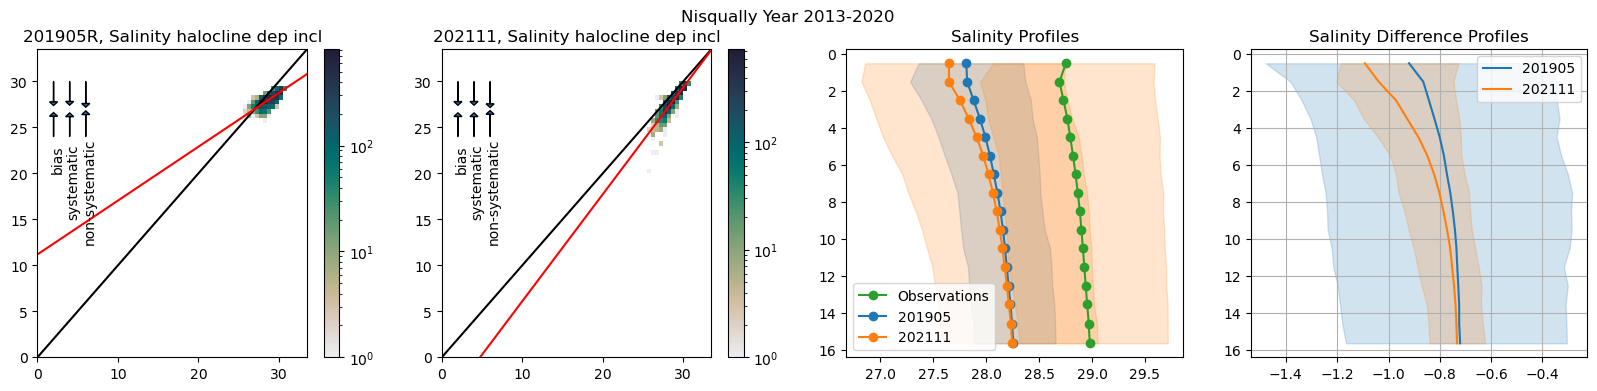

In [59]:
idepth = 0
jdepth = 15
region = 'Nisqually'

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
                           [2015, 2016, 2017, 2018, 2019], 
                           idepth, jdepth, 'test')

print(f'\033[1m{region}\033[1m')
display(results[results.region == region].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
               [2015, 2016, 2017, 2018, 2019],
               idepth, jdepth, Nisqually, region, 'halocline dep incl')

In [60]:
# stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
#                [2015, 2016, 2017, 2018, 2019],
#                idepth, jdepth, Elwha, 'Elwha', 'top5m')

Cowichan


/tmp/ipykernel_2096566/2185682482.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(alltogether.to_latex(column_format='lccccccccccl',


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,8526,-1.34,1.97,1.45,0.346,-0.88,-26.6,1.74,1.78,-1.55
202111,8526,-1.12,1.6,1.14,0.268,-0.511,-15.8,1.29,1.3,-1.08


         Unnamed: 0    Year  Month   Day       Hour        Lat         Lon  \
0                 0  2013.0    1.0  10.0  17.118056  49.329667 -124.081000   
1353           1353  2013.0    2.0  13.0  16.696111  49.318167 -123.934833   
2895           2895  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
2896           2896  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
3533           3533  2013.0    3.0   7.0  16.628056  49.316500 -123.945667   
...             ...     ...    ...   ...        ...        ...         ...   
2802459      171184     NaN    NaN   NaN        NaN  49.171881 -123.630172   
2802460      171185     NaN    NaN   NaN        NaN  49.174657 -123.637464   
2802461      171186     NaN    NaN   NaN        NaN  49.177499 -123.644701   
2802462      171187     NaN    NaN   NaN        NaN  49.180270 -123.652008   
2802463      171188     NaN    NaN   NaN        NaN  49.183008 -123.659329   

                Z         SA        CT  ...  conservative tempe

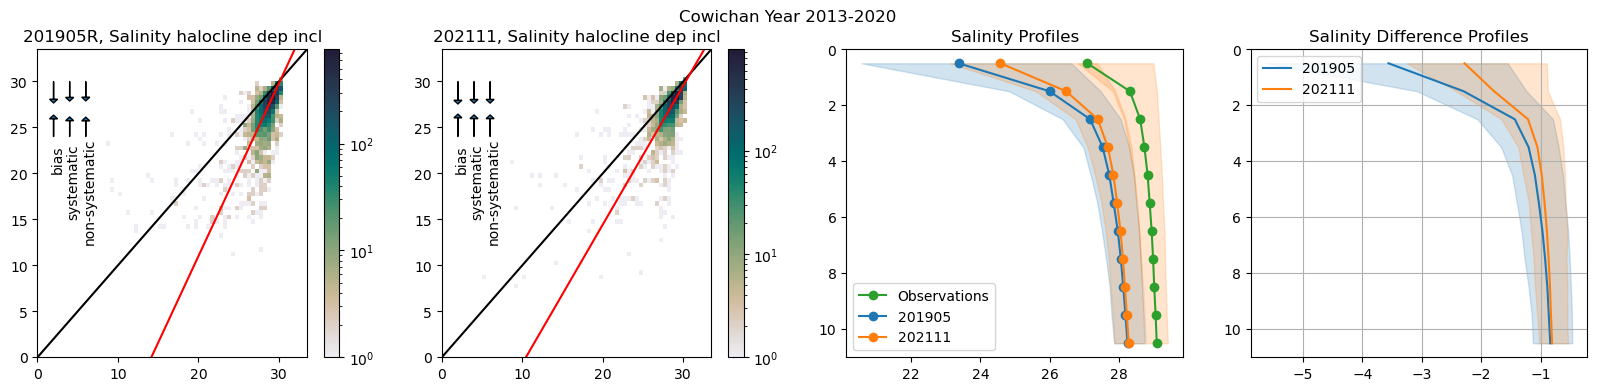

In [61]:
idepth = 0
jdepth = 10
region = 'Cowichan'

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
                           [2015, 2016, 2017, 2018, 2019], 
                           idepth, jdepth, 'test')

print(f'\033[1m{region}\033[1m')
display(results[results.region == region].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
               [2015, 2016, 2017, 2018, 2019],
               idepth, jdepth, Cowichan, region, 'halocline dep incl')

Nanaimo


/tmp/ipykernel_2096566/2185682482.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(alltogether.to_latex(column_format='lccccccccccl',


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,561,-0.498,1.48,1.4,0.121,-0.521,-14.9,1.06,1.44,-2.58
202111,561,-0.257,1.24,1.21,0.0981,-0.325,-9.24,0.636,1.28,-2.28


         Unnamed: 0    Year  Month   Day       Hour        Lat         Lon  \
0                 0  2013.0    1.0  10.0  17.118056  49.329667 -124.081000   
1353           1353  2013.0    2.0  13.0  16.696111  49.318167 -123.934833   
2895           2895  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
2896           2896  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
3533           3533  2013.0    3.0   7.0  16.628056  49.316500 -123.945667   
...             ...     ...    ...   ...        ...        ...         ...   
2802459      171184     NaN    NaN   NaN        NaN  49.171881 -123.630172   
2802460      171185     NaN    NaN   NaN        NaN  49.174657 -123.637464   
2802461      171186     NaN    NaN   NaN        NaN  49.177499 -123.644701   
2802462      171187     NaN    NaN   NaN        NaN  49.180270 -123.652008   
2802463      171188     NaN    NaN   NaN        NaN  49.183008 -123.659329   

                Z         SA        CT  ...  conservative tempe

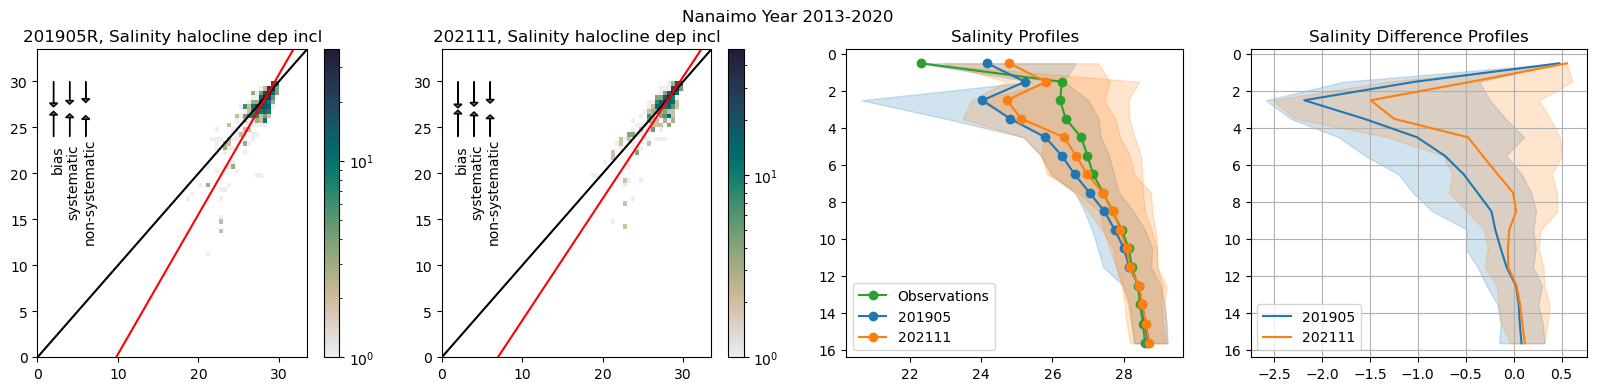

In [62]:
idepth = 0
jdepth = 15
region = 'Nanaimo'

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
                           [2015, 2016, 2017, 2018, 2019], 
                           idepth, jdepth, 'test')

print(f'\033[1m{region}\033[1m')
display(results[results.region == region].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
               [2015, 2016, 2017, 2018, 2019],
               idepth, jdepth, Nanaimo, region, 'halocline dep incl')

Puntledge


/tmp/ipykernel_2096566/2185682482.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(alltogether.to_latex(column_format='lccccccccccl',


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2007,0.106,0.814,0.807,0.157,0.252,7.13,0.321,0.671,0.352
202111,2007,0.364,0.866,0.786,0.168,0.253,7.41,0.474,0.65,0.359


         Unnamed: 0    Year  Month   Day       Hour        Lat         Lon  \
0                 0  2013.0    1.0  10.0  17.118056  49.329667 -124.081000   
1353           1353  2013.0    2.0  13.0  16.696111  49.318167 -123.934833   
2895           2895  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
2896           2896  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
3533           3533  2013.0    3.0   7.0  16.628056  49.316500 -123.945667   
...             ...     ...    ...   ...        ...        ...         ...   
2802459      171184     NaN    NaN   NaN        NaN  49.171881 -123.630172   
2802460      171185     NaN    NaN   NaN        NaN  49.174657 -123.637464   
2802461      171186     NaN    NaN   NaN        NaN  49.177499 -123.644701   
2802462      171187     NaN    NaN   NaN        NaN  49.180270 -123.652008   
2802463      171188     NaN    NaN   NaN        NaN  49.183008 -123.659329   

                Z         SA        CT  ...  conservative tempe

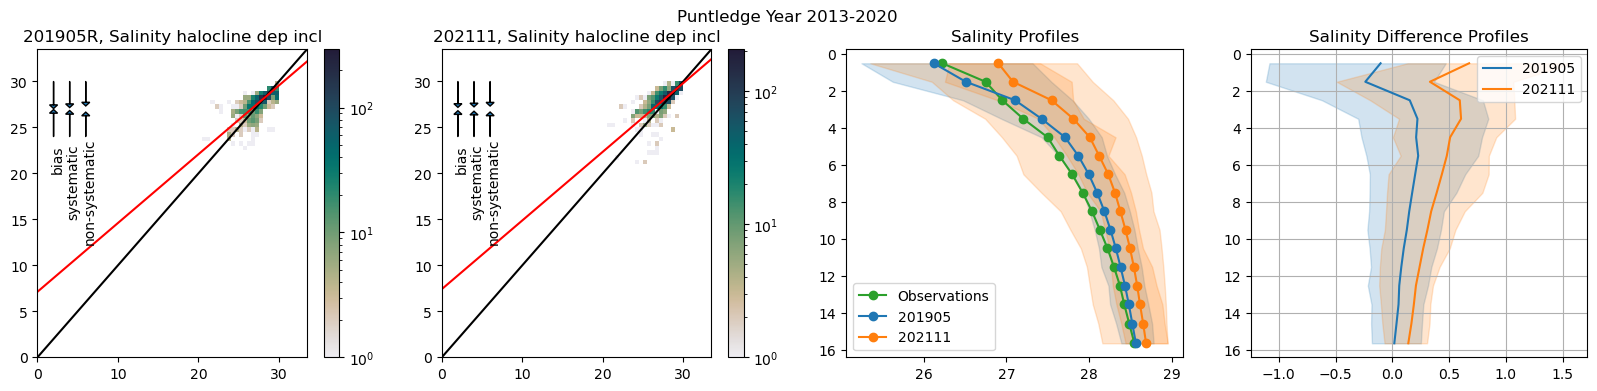

In [63]:
idepth = 0
jdepth = 15
region = 'Puntledge'

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
                           [2015, 2016, 2017, 2018, 2019], 
                           idepth, jdepth, 'test')

print(f'\033[1m{region}\033[1m')
display(results[results.region == region].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
               [2015, 2016, 2017, 2018, 2019],
               idepth, jdepth, Puntledge, region, 'halocline dep incl')

Salmon


/tmp/ipykernel_2096566/2185682482.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(alltogether.to_latex(column_format='lccccccccccl',


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,270,0.183,0.285,0.218,0.146,0.232,7.33,0.207,0.177,0.364
202111,270,0.201,0.305,0.229,0.18,0.337,10.6,0.245,0.158,0.504


         Unnamed: 0    Year  Month   Day       Hour        Lat         Lon  \
0                 0  2013.0    1.0  10.0  17.118056  49.329667 -124.081000   
1353           1353  2013.0    2.0  13.0  16.696111  49.318167 -123.934833   
2895           2895  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
2896           2896  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
3533           3533  2013.0    3.0   7.0  16.628056  49.316500 -123.945667   
...             ...     ...    ...   ...        ...        ...         ...   
2802459      171184     NaN    NaN   NaN        NaN  49.171881 -123.630172   
2802460      171185     NaN    NaN   NaN        NaN  49.174657 -123.637464   
2802461      171186     NaN    NaN   NaN        NaN  49.177499 -123.644701   
2802462      171187     NaN    NaN   NaN        NaN  49.180270 -123.652008   
2802463      171188     NaN    NaN   NaN        NaN  49.183008 -123.659329   

                Z         SA        CT  ...  conservative tempe

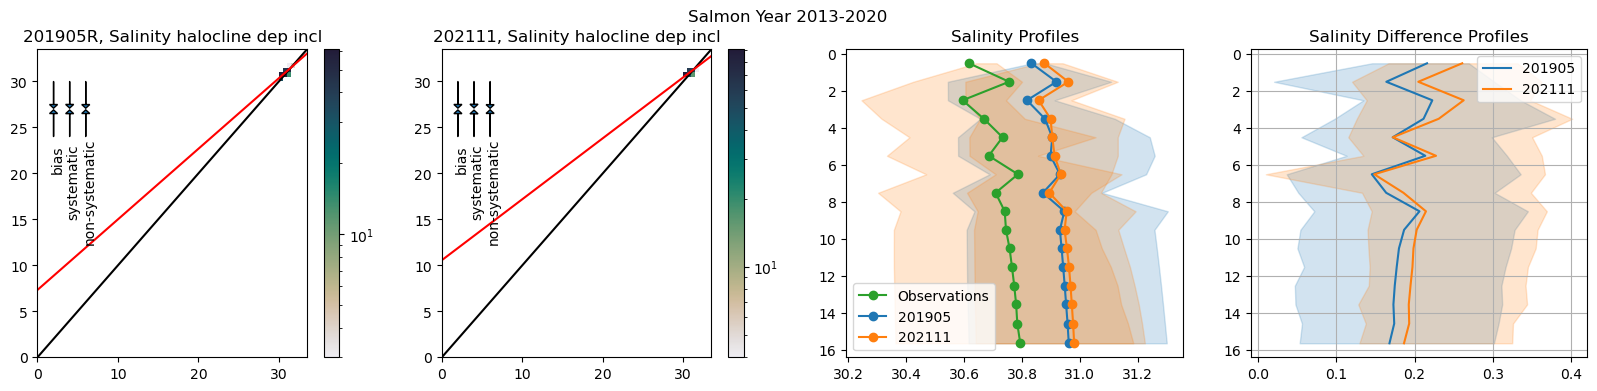

In [64]:
idepth = 0
jdepth = 15
region = 'Salmon'

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
                           [2015, 2016, 2017, 2018, 2019], 
                           idepth, jdepth, 'test')

print(f'\033[1m{region}\033[1m')
display(results[results.region == region].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
               [2015, 2016, 2017, 2018, 2019],
               idepth, jdepth, Salmon, region, 'halocline dep incl')

In [65]:
# stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
#                [2015, 2016, 2017, 2018, 2019],
#                idepth, jdepth, Homathko, 'Homathko', 'top5m')

Squamish


/tmp/ipykernel_2096566/2185682482.py:51: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(alltogether.to_latex(column_format='lccccccccccl',


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,25,0.182,2.1,2.09,0.228,-0.543,-14.3,1.12,2.5,-0.762
202111,25,0.928,1.72,1.44,0.187,0.0196,1.45,0.929,1.43,0.029


         Unnamed: 0    Year  Month   Day       Hour        Lat         Lon  \
0                 0  2013.0    1.0  10.0  17.118056  49.329667 -124.081000   
1353           1353  2013.0    2.0  13.0  16.696111  49.318167 -123.934833   
2895           2895  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
2896           2896  2013.0    3.0   5.0  16.368611  49.325667 -123.952000   
3533           3533  2013.0    3.0   7.0  16.628056  49.316500 -123.945667   
...             ...     ...    ...   ...        ...        ...         ...   
2802459      171184     NaN    NaN   NaN        NaN  49.171881 -123.630172   
2802460      171185     NaN    NaN   NaN        NaN  49.174657 -123.637464   
2802461      171186     NaN    NaN   NaN        NaN  49.177499 -123.644701   
2802462      171187     NaN    NaN   NaN        NaN  49.180270 -123.652008   
2802463      171188     NaN    NaN   NaN        NaN  49.183008 -123.659329   

                Z         SA        CT  ...  conservative tempe

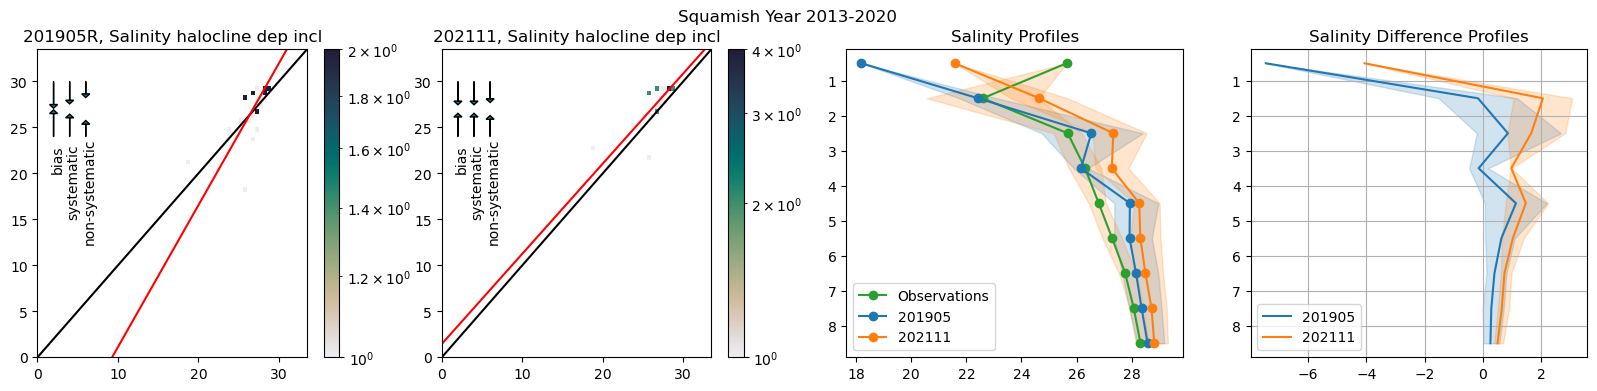

In [66]:
idepth = 0
jdepth = 10
region = 'Squamish'

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
                           [2015, 2016, 2017, 2018, 2019], 
                           idepth, jdepth, 'test')

print(f'\033[1m{region}\033[1m')
display(results[results.region == region].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
               [2015, 2016, 2017, 2018, 2019],
               idepth, jdepth, Squamish, region, 'halocline dep incl')

## Get more data

In [67]:
CIOOS_DFO_Bute = pd.read_csv('CIOOS/IOS_CTD_Profiles_DFO_ButeInlet.csv')
# CIOOS_DFO_Bute.columns
CIOOS_DFO_Bute[['latitude', 'longitude', 'time', 'depth', 'sea_water_practical_salinity', 'PSALST01', 'PSALST02', 'SSALST01']]

,latitude,longitude,time,depth,sea_water_practical_salinity,PSALST01,PSALST02,SSALST01
0,degrees_north,degrees_east,UTC,m,PSS-78,PSS-78,PSS-78,PPT
1,50.666534,-126.77157,2023-05-11T16:52:15Z,0.9,31.0996,31.0996,NaN,NaN
2,50.666534,-126.77157,2023-05-11T16:52:15Z,1.9,31.1139,31.1139,NaN,NaN
3,50.666534,-126.77157,2023-05-11T16:52:15Z,2.9,31.1368,31.1368,NaN,NaN
4,50.666534,-126.77157,2023-05-11T16:52:15Z,3.9,31.1449,31.1449,NaN,NaN
...,...,...,...,...,...,...,...,...
1522,50.842247,-127.71657,2023-05-11T23:55:15Z,104.1,31.9891,31.9891,NaN,NaN
1523,50.842247,-127.71657,2023-05-11T23:55:15Z,105.1,32.0034,32.0034,NaN,NaN
1524,50.842247,-127.71657,2023-05-11T23:55:15Z,106.1,32.0057,32.0057,NaN,NaN
1525,50.842247,-127.71657,2023-05-11T23:55:15Z,107.1,32.0077,32.0077,NaN,NaN
